#  Practical assessment for Business Intelligence Analyst

##  Problem Setting
- You are supporting an e-commerce platform
- Currently, the decision making at this company is not
very data-informed
- They do not own a data warehouse and do not have automated reports
- You are able to access backend data about customers and orders

## Task
In 2 weeks time the CEO of the company has to present to investment board members how the company is currently doing. While preparing his presentation, he assumes the following:
- The company is growing in terms of customers and conversions and growth is healthy.
- The company should invest more in Offline sales, which look promising.
- There are certain customer segments that behave significantly different than others.

He wants you to analyze and make sense of the given data to help him support/disagree with his assumptions.

##  Resources

### customers.csv

| column | content |
|---|---|
| customer_id | an identifier for the customer |
| first_order_day | the date, when the customer ordered the first time |
| customer_type | B2B or B2C |
| primary_sales_channel | offline or online |

### orders.csv

| column | content |
|---|---|
| order_id | an identifier for the order |
| customer_id | an identifier for the customer |
| order_date | date when the order was placed |
| revenue | revenue in EUR that is generated by this order |



### monthly_revenue_2016.csv
This csv contains historical data for the monthly revenue in 2016 that was aggregated by a former data analyst


## 1. data import, cleaning and wrangling

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
path = "data/"

customers = pd.read_csv(path+"customers.csv")
orders = pd.read_csv(path+"orders.csv")
monthly_revenue = pd.read_csv(path+"monthly_revenue_2016.csv")

### customers

In [3]:
customers.head()

,customer_id,customer_type,primary_sales_channel,first_order_day_fk
0,K0100097,B2C,Offline,20170117
1,K0100437,B2C,Offline,20170118
2,K0100451,B2C,Offline,20170118
3,K0100585,B2C,Offline,20170119
4,K0100681,B2C,Offline,20170120


In [4]:
print(customers.shape)
print(customers.dtypes)

(11628, 4)
customer_id              object
customer_type            object
primary_sales_channel    object
first_order_day_fk        int64
dtype: object


In [5]:
customers["customer_type"].value_counts()/len(customers)

B2C    0.995872
B2B    0.004128
Name: customer_type, dtype: float64

In [6]:
customers["primary_sales_channel"].value_counts()/len(customers)

Online     0.868163
Offline    0.131837
Name: primary_sales_channel, dtype: float64

In [7]:
customers["customer_id"].nunique()

11628

In [8]:
customers.isna().sum()

customer_id              0
customer_type            0
primary_sales_channel    0
first_order_day_fk       0
dtype: int64

- unique customers id (same unique values as dataset length)
- 2 types of customers, 99,5% B2C
- 2 types of channels, almost 87% online
- no NaN
- we need to work with the date format

In [9]:
# transform format into date
customers["date_first_order"] = pd.to_datetime(customers["first_order_day_fk"], format="%Y%m%d")

In [10]:
# drop column
customers = customers.drop(columns=["first_order_day_fk"])

In [11]:
customers.describe().T

,count,unique,top,freq,first,last
customer_id,11628,11628,K4048932007,1,NaT,NaT
customer_type,11628,2,B2C,11580,NaT,NaT
primary_sales_channel,11628,2,Online,10095,NaT,NaT
date_first_order,11628,786,2017-01-08 00:00:00,118,2014-09-03,2017-06-30


### orders

In [12]:
orders

,order_id,customer_id,order_date_fk,revenue
0,96149,K4078373803.0,20170101,128.70
1,281101,K3929324291.0,20170101,125.33
2,96244,K1706191515.0,20170101,118.09
3,96162,K4291564253.0,20170101,80.80
4,96204,K3541486465.0,20170101,75.80
...,...,...,...,...
24061,291614,K424139434.0,20170630,12.97
24062,303595,K2958888446.0,20170630,11.98
24063,293138,K708187630.0,20170630,11.98
24064,298788,K3477419091.0,20170630,11.89


In [13]:
orders.dtypes

order_id           int64
customer_id       object
order_date_fk      int64
revenue          float64
dtype: object

- order_id doesn't refer to a number, therefore should be object
- change order_date_fk format
- customer_id has a ".0" at the end, remove use the same type as in the customer dataset


In [14]:
# transform object
orders["order_id"] = orders["order_id"].astype("object")

In [15]:
orders["order_date"] = pd.to_datetime(orders["order_date_fk"], format="%Y%m%d")
# drop column
orders = orders.drop(columns=["order_date_fk"])

In [16]:
orders["customer_id"] = orders["customer_id"].str[:-2]

In [17]:
orders

,order_id,customer_id,revenue,order_date
0,96149,K4078373803,128.70,2017-01-01
1,281101,K3929324291,125.33,2017-01-01
2,96244,K1706191515,118.09,2017-01-01
3,96162,K4291564253,80.80,2017-01-01
4,96204,K3541486465,75.80,2017-01-01
...,...,...,...,...
24061,291614,K424139434,12.97,2017-06-30
24062,303595,K2958888446,11.98,2017-06-30
24063,293138,K708187630,11.98,2017-06-30
24064,298788,K3477419091,11.89,2017-06-30


### monthly revenue

In [18]:
# add year to monthly revenue
monthly_revenue["year"] = "2016" + " " + monthly_revenue["month"]
# convert into date (attributed to first day of the month)
monthly_revenue["date"] = pd.to_datetime(monthly_revenue["year"])
# drop columns "month" & "year"
monthly_revenue = monthly_revenue.drop(columns=["month","year"])

In [19]:
# add year-month to orders
orders["month"] = pd.DatetimeIndex(orders["order_date"]).month
orders["year"] = pd.DatetimeIndex(orders["order_date"]).year
orders["year_month"] = pd.to_datetime(orders["year"].astype(str)+"-"+orders["month"].astype(str))

In [20]:
# group by month
monthly_revenue_2017 = orders.groupby(["year_month"]).sum()["revenue"]
monthly_revenue_2017 = monthly_revenue_2017.to_frame().reset_index()

In [21]:
# re-arrange monthly_revenue_2017
monthly_revenue_2017 = monthly_revenue_2017[["year_month","revenue"]]

In [22]:
# re-arrange monthly_revenue
monthly_revenue["revenue"] = monthly_revenue["revenue(EUR)"]
monthly_revenue["year_month"] = monthly_revenue["date"]
monthly_revenue_2016 = monthly_revenue[["year_month","revenue"]]

In [23]:
# concat revenue 2016 & 2017
monthly_revenue = pd.concat([monthly_revenue_2016, monthly_revenue_2017]).reset_index(drop=True)
monthly_revenue

,year_month,revenue
0,2016-01-01,223803.40
1,2016-02-01,152010.60
2,2016-03-01,207492.59
3,2016-04-01,198400.37
4,2016-05-01,172665.00
5,2016-06-01,92489.00
6,2016-07-01,88955.01
7,2016-08-01,154239.94
8,2016-09-01,175366.28
9,2016-10-01,194802.03


### monthly orders

In [24]:
monthly_orders = orders.groupby(by=["year_month"]).agg(["count", "sum","mean"])["revenue"].reset_index()
monthly_orders

,year_month,count,sum,mean
0,2017-01-01,6462,295974.75,45.802344
1,2017-02-01,3699,211228.35,57.104177
2,2017-03-01,3604,679477.52,188.534273
3,2017-04-01,3851,261289.01,67.849652
4,2017-05-01,4119,229030.20,55.603350
5,2017-06-01,2331,134431.25,57.671064


# Questions
## 1. The company is growing in terms of customers and conversions and growth is healthy

break down this questions in 3 parts: 

##### 1.1 the amount of (new) customers is increasing

##### 1.2 the amount conversions is increasing
we need to define "conversions" in this context, not obvious in my understanding.
2 metrics can be assumed:
- average value per order
- average orders per customer

##### 1.3 the growth is healthy
the assumption here is that the growth is healthy if there is a positive trend in the growth of revenue in general

### 1.1 the amount of (new) customers is increasing

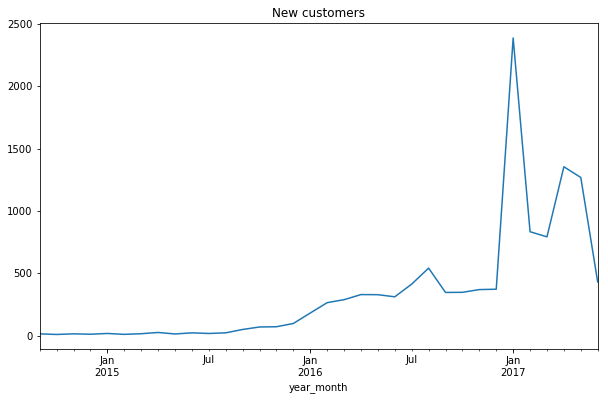

In [25]:
customers["year_month"] = pd.to_datetime(customers["date_first_order"]).dt.to_period("M").astype(str)

customers["year_month"] = pd.to_datetime(customers["year_month"])

# plot line
fig, ax = plt.subplots(figsize=(10,6))
customers.groupby(["year_month"]).count()["customer_id"].plot().title.set_text("New customers");

Overall, customers are increasing. Knowing the distinction between B2B and B2C, inspect in detail

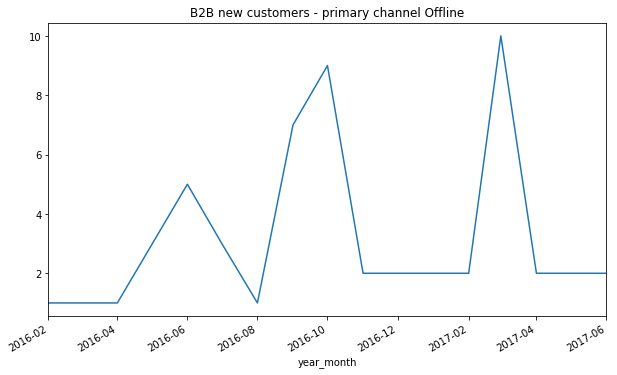

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
# B2B there are only Offline as primary channel
(customers[customers["customer_type"].eq("B2B")]
          .groupby(["year_month"])                              
          .count()["customer_id"]     
          .plot()     
          .title.set_text("B2B new customers - primary channel Offline"))

B2B customers are very small in amount to be consider overall the growth in customers. Maybe valuable in terms of orders and revenue (inspect later), but not significant in terms of number of customers

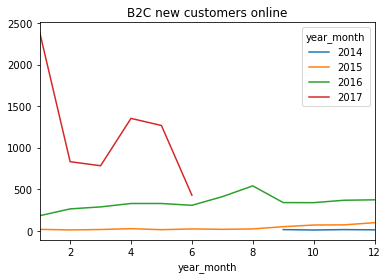

In [27]:
# aggregate monthly new customers b2c
new_b2c_customers_monthly = ((customers[customers["customer_type"].eq("B2C")]
                                .groupby(["year_month"])                              
                                .count()[["customer_id"]])
                                .reset_index()
                                .rename(columns={"customer_id":"new_customers_b2c"}))


# compare Year over Year
pd.pivot_table(new_b2c_customers_monthly,
               index=pd.DatetimeIndex(new_b2c_customers_monthly["year_month"]).month,
               columns=pd.DatetimeIndex(new_b2c_customers_monthly["year_month"]).year,
               values="new_customers_b2c").plot().title.set_text("B2C new customers online");

Year over year, we see a steady increase, but in 2017, the pattern changed significantly, having an extraordinary peak in January (also April&May), with a strong decrease in June

#### Overall the customers are growing, but it is necessary to monitor the decrease in June 2017, if it is a "hangover" of the peak in the previous months or as a change of trend

### 1.2 The amount of conversions is increasing

As mentioned before, here the problematic aspect is to define what is "conversion"

In [28]:
# calculate avg value per order
orders.groupby(by="year_month").mean()[["revenue"]]

,revenue
year_month,
2017-01-01,45.802344
2017-02-01,57.104177
2017-03-01,188.534273
2017-04-01,67.849652
2017-05-01,55.603350
2017-06-01,57.671064


we see a peak in march in regards of the avg value. Let's see in detail

In [29]:
# combine orders and information available about customers
orders_enriched = (pd.merge(left=orders, right=customers, how="left", left_on="customer_id", right_on="customer_id")
                   .drop(columns=["year_month_y"])
                   .rename(columns={"year_month_x":"year_month"}))
orders_enriched

,order_id,customer_id,revenue,order_date,month,year,year_month,customer_type,primary_sales_channel,date_first_order
0,96149,K4078373803,128.70,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-05-06
1,281101,K3929324291,125.33,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-07-27
2,96244,K1706191515,118.09,2017-01-01,1,2017,2017-01-01,B2C,Online,2015-07-18
3,96162,K4291564253,80.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-09-27
4,96204,K3541486465,75.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-10-04
...,...,...,...,...,...,...,...,...,...,...
24061,291614,K424139434,12.97,2017-06-30,6,2017,2017-06-01,B2C,Online,2017-01-19
24062,303595,K2958888446,11.98,2017-06-30,6,2017,2017-06-01,B2C,Online,2016-12-05
24063,293138,K708187630,11.98,2017-06-30,6,2017,2017-06-01,B2C,Online,2016-05-08
24064,298788,K3477419091,11.89,2017-06-30,6,2017,2017-06-01,B2C,Online,2015-08-18


In [30]:
# check the value of each type of customers in the total of the revenue 
sum_order_value_customer_channel = (orders_enriched.groupby(by=["year_month","customer_type","primary_sales_channel"])
                                                   .sum()
                                                   .reset_index()
                                                   .set_index("year_month"))

sum_order_value_customer_channel#["monthly_revenue"] 

monthly_revenue

sum_order_value_customer_channel["monthly_revenue"] = (sum_order_value_customer_channel.merge(monthly_revenue,
                                                                                             left_on="year_month", 
                                                                                             right_on="year_month")
                                                                                        .set_index("year_month")["revenue_y"])

sum_order_value_customer_channel["monthly_revenue_share"] = round(sum_order_value_customer_channel["revenue"]/sum_order_value_customer_channel["monthly_revenue"],2)

sum_order_value_customer_channel

,customer_type,primary_sales_channel,revenue,month,year,monthly_revenue,monthly_revenue_share
year_month,,,,,,,
2017-01-01,B2B,Offline,11980.18,23,46391,295974.75,0.04
2017-01-01,B2C,Offline,10072.44,359,724103,295974.75,0.03
2017-01-01,B2C,Online,273922.13,6080,12263360,295974.75,0.93
2017-02-01,B2B,Offline,16777.09,52,52442,211228.35,0.08
2017-02-01,B2C,Offline,7928.55,424,427604,211228.35,0.04
2017-02-01,B2C,Online,186522.71,6922,6980837,211228.35,0.88
2017-03-01,B2B,Offline,490890.83,102,68578,679477.52,0.72
2017-03-01,B2C,Offline,7669.85,675,453825,679477.52,0.01
2017-03-01,B2C,Online,180916.84,10035,6746865,679477.52,0.27


In [31]:
# group by month, customer type & primary sales channel 
avg_order_value_customer_channel = (orders_enriched.groupby(by=["year_month","customer_type","primary_sales_channel"])
                                                   .mean()
                                                   .reset_index()
                                                   .set_index("year_month"))

avg_order_value_customer_channel.sort_values(["customer_type","primary_sales_channel"])

,customer_type,primary_sales_channel,revenue,month,year
year_month,,,,,
2017-01-01,B2B,Offline,520.877391,1,2017
2017-02-01,B2B,Offline,645.272692,2,2017
2017-03-01,B2B,Offline,14437.965588,3,2017
2017-04-01,B2B,Offline,2852.424400,4,2017
2017-05-01,B2B,Offline,840.300345,5,2017
2017-06-01,B2B,Offline,1036.097059,6,2017
2017-01-01,B2C,Offline,28.056936,1,2017
2017-02-01,B2C,Offline,37.398821,2,2017
2017-03-01,B2C,Offline,34.088222,3,2017


In [32]:
# avg value customers
avg_order_value_customer = (orders_enriched.groupby(by=["year_month","customer_type"])
                                           .mean()
                                           .reset_index()
                                           .set_index("year_month"))

avg_order_value_customer.sort_values(by="customer_type")

,customer_type,revenue,month,year
year_month,,,,
2017-01-01,B2B,520.877391,1,2017
2017-02-01,B2B,645.272692,2,2017
2017-03-01,B2B,14437.965588,3,2017
2017-04-01,B2B,2852.424400,4,2017
2017-05-01,B2B,840.300345,5,2017
2017-06-01,B2B,1036.097059,6,2017
2017-01-01,B2C,44.105384,1,2017
2017-02-01,B2C,52.940719,2,2017
2017-03-01,B2C,52.825403,3,2017


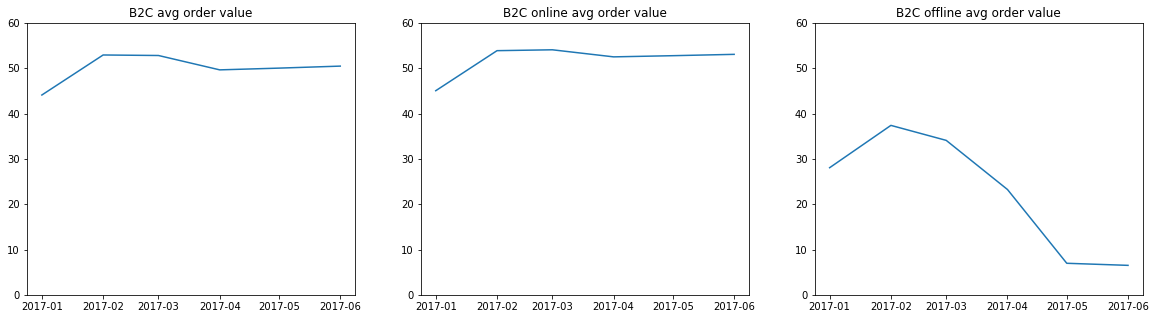

In [33]:
# fig and axis
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# set fix y axis to better compare values

# avg value of order every B2C customer 
ax1.title.set_text("B2C avg order value")
ax1.plot(avg_order_value_customer[avg_order_value_customer["customer_type"].eq("B2C")]["revenue"])
ax1.set_ylim([0,60])

# avg value of order every B2C customer, only considering online as primary channel
ax2.title.set_text("B2C online avg order value")
ax2.plot(avg_order_value_customer_channel[avg_order_value_customer_channel["customer_type"].eq("B2C")&avg_order_value_customer_channel["primary_sales_channel"].eq("Online")]["revenue"])
ax2.set_ylim([0,60])

# avg value of order every B2C customer only considering offline as primaryt channel 
ax3.title.set_text("B2C offline avg order value")
ax3.plot(avg_order_value_customer_channel[avg_order_value_customer_channel["customer_type"].eq("B2C")&avg_order_value_customer_channel["primary_sales_channel"].eq("Offline")]["revenue"])
ax3.set_ylim([0,60]);

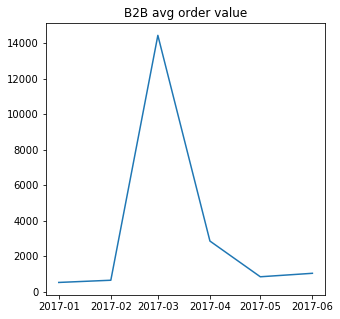

In [34]:
# plot avg value orders B2B (only offline as primary channel)
fig, ax = plt.subplots(figsize = (5,5))
ax.title.set_text("B2B avg order value")
ax.plot(avg_order_value_customer[avg_order_value_customer["customer_type"].eq("B2B")]["revenue"]);



Considering metric of conversions as avg order value
- in general, avg order value is stable, with the exception of the month of march, which correspond enterily to the B2B customers
- In B2B customers, the peak of march is of over 20 times bigger than the previous months, but even discarding this outlier, the trend seems positive (avg value in June double the avg value in January)
- In B2C customers, the trend seems very stable (except January, around 10% smaller)
- However, this is due the Online B2C customers (which represents over 80% of the revenue -except March-April-)
- B2C Offline customers, sank from 36 avg value (in February) to 6 (in June), **6 times lower**

#### in summary: if conversion is measure by the avg order value, the trend is positive for the B2B, remains stable for the B2C online and is going down for B2C Offline (wich has a marginal impact in the last 2 months)

In [35]:
# calculate amount of orders per customer
orders_enriched.head()

,order_id,customer_id,revenue,order_date,month,year,year_month,customer_type,primary_sales_channel,date_first_order
0,96149,K4078373803,128.70,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-05-06
1,281101,K3929324291,125.33,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-07-27
2,96244,K1706191515,118.09,2017-01-01,1,2017,2017-01-01,B2C,Online,2015-07-18
3,96162,K4291564253,80.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-09-27
4,96204,K3541486465,75.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-10-04


In [36]:
unique_customers_monthly = (orders_enriched.groupby(["year_month","customer_type","primary_sales_channel"])
                                           .agg({"order_id":"nunique", "customer_id":"nunique"})
                                           .reset_index()
                                           .set_index("year_month"))

unique_customers_monthly["avg_orders_amount"] = round(unique_customers_monthly["order_id"]/unique_customers_monthly["customer_id"],2)

unique_customers_monthly = unique_customers_monthly.rename(columns={"order_id":"unique_orders", "customer_id":"unique_customers"})

unique_customers_monthly.sort_values(["customer_type","primary_sales_channel"])

,customer_type,primary_sales_channel,unique_orders,unique_customers,avg_orders_amount
year_month,,,,,
2017-01-01,B2B,Offline,23,20,1.15
2017-02-01,B2B,Offline,26,23,1.13
2017-03-01,B2B,Offline,34,22,1.55
2017-04-01,B2B,Offline,25,19,1.32
2017-05-01,B2B,Offline,29,22,1.32
2017-06-01,B2B,Offline,17,12,1.42
2017-01-01,B2C,Offline,359,299,1.20
2017-02-01,B2C,Offline,212,212,1.00
2017-03-01,B2C,Offline,225,225,1.00


Again, in March, for B2B customers, there was a significant increase of the avg amount of orders per unique customer, and after that, maintain a positive trend

there is no trend can be infered for B2C customers in regards of the avg amount of orders per unique customer (neither Online nor Offline)

Therefore, reinforce the idea already exposed before:
- B2B: positive trend of conversions, with spectacular peak in march
- B2C: stable trend in conversions

### 1.3 Growth is healthy
the assumption here is that the growth is healthy if there is a positive trend in the growth of revenue in general

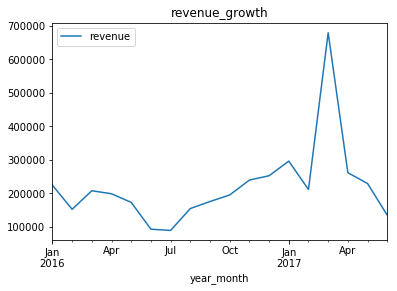

In [37]:
monthly_revenue.set_index("year_month").plot().title.set_text("revenue_growth");


intuitively we can infer a positive trend, but declining in the last months, for a better understanding:
- calculate the linear regression for the period of 18 months (data available)
- compare growth YoY in the first semesters 2016 & 2017 (data available)

In [38]:
# prepare data for fitted line

# create time variable
monthly_revenue_lr = monthly_revenue.assign(t=monthly_revenue.index+1)

# create constant
monthly_revenue_lr = monthly_revenue_lr.assign(constant=1)

monthly_revenue_lr = monthly_revenue_lr.set_index("year_month")

In [39]:
# run linear regression
rev_train = monthly_revenue_lr.loc["2016-01-01":"2017-06-01"]

# create variables
y = rev_train["revenue"]
X = rev_train[["constant", "t"]]
lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [40]:
results.summary()

/Users/ivanlopezlobato/miniconda3/envs/code_red/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.498
Date:                Mon, 29 Jun 2020   Prob (F-statistic):              0.134
Time:                        15:40:29   Log-Likelihood:                -235.29
No. Observations:                  18   AIC:                             474.6
Df Residuals:                      16   BIC:                             476.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    1.369e+05      6e+04      2.282      0.036    9751.434    2.64e+05
t           8761.3767   5543.040      1.581      0.134   -2989.343    2.05e+04
==============================================================================
Omnibus:                       27.382   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.428
Skew:                           2.310   Prob(JB):                     8.28e-11
Kurtosis:                       9.369   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
results.params

constant    136945.397778
t             8761.376667
dtype: float64

In [42]:
# make a copy
monthly_revenue_pred = monthly_revenue_lr.copy()

# assign values of linear regression to plot
monthly_revenue_pred = monthly_revenue_pred.assign(predicted_revenue=(results.params["constant"] + monthly_revenue_pred["t"] * results.params["t"]))

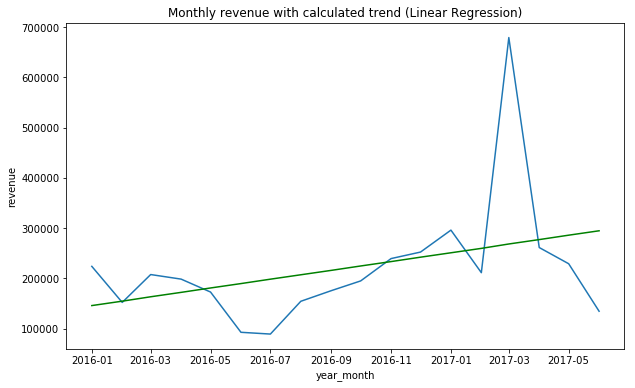

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=monthly_revenue_pred.loc["2016-01-01":"2017-06-01"],
             x=monthly_revenue_pred.loc["2016-01-01":"2017-06-01"].index,
             y="revenue",
             ax=ax);
ax.plot(monthly_revenue_pred.loc["2016-01-01":"2017-06-01", "predicted_revenue"], color="green")
ax.title.set_text("Monthly revenue with calculated trend (Linear Regression)");

We observe that the trend (linear regression) of the values along 18 months is ascending in regards of the revenue, so we can state that we are "healthy" growing
However, we can detect an unexpected peak in March 2017, that might be the main cause the growth.

to check in detail, we visualize growth YoY

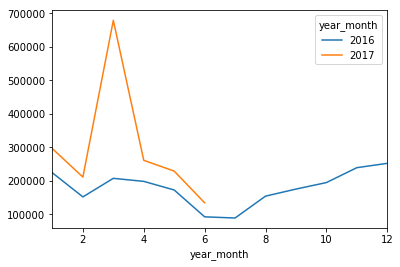

In [44]:
# compare Year over Year
pd.pivot_table(monthly_revenue,
               index=pd.DatetimeIndex(monthly_revenue["year_month"]).month,
               columns=pd.DatetimeIndex(monthly_revenue["year_month"]).year,
               values="revenue").plot();

Visually we can infere a seasonal behaviour, with a growth YoY

to observe more in detail, we calculate the actual growth YoY in %

In [45]:
monthly_revenue_yoy = (pd.pivot_table(monthly_revenue,
                                     index=pd.DatetimeIndex(monthly_revenue["year_month"]).month,
                                     columns=pd.DatetimeIndex(monthly_revenue["year_month"]).year,
                                     values="revenue")
                        .rename_axis(None, axis=1))

monthly_revenue_yoy["growth"] = (monthly_revenue_yoy[2017]-monthly_revenue_yoy[2016])/monthly_revenue_yoy[2016]

monthly_revenue_yoy[:6][["growth"]]

,growth
year_month,
1,0.322477
2,0.389563
3,2.274707
4,0.316978
5,0.326443
6,0.453484


we can check that the percentual growth YoY in the first 6 months of 2017 is steady, always positive in a range of (31-45%), with the additional push on March of a 227% growth in comparison to the same period of 2016

in general, revenue growth seems healthy, with seasonal fluctiations

The peak in March was driven by B2B customers, which increased significantly the avg order value as well as the amount of orders per unique customer

## 2. The company should invest more in Offline sales, which look promising.

in which sense is "promising"?

in 2017 it is opened this new line of customers with offline as primary channel
- inspect volume of offline vs online (new customers & revenue), **only for B2C**

B2B customers are all Offline, and it is assumed that the different behavior is due the nature of the type over the primary channel 

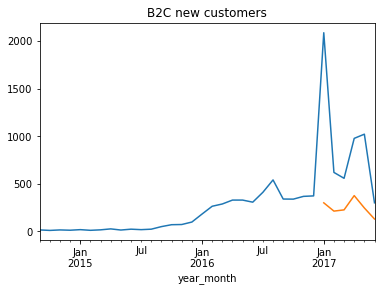

In [46]:
(customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Online")]
          .groupby(["year_month"])                              
          .count()["customer_id"]     
          .plot()     
          .title.set_text("B2C new customers"))
(customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Offline")]
          .groupby(["year_month"])                              
          .count()["customer_id"]     
          .plot());

In [47]:
b2c_online_2017 = (customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Online")&customers["year_month"].ge("2017-01")]
                  .groupby(["year_month"])                              
                  .count()["customer_id"]).sum()

b2c_offline_2017 = (customers[customers["customer_type"].eq("B2C")&customers["primary_sales_channel"].eq("Offline")&customers["year_month"].ge("2017-01")]
                  .groupby(["year_month"])                              
                  .count()["customer_id"]).sum()

print("percent of new customers B2C with offline as primary channel in 2017:")
round((b2c_offline_2017 / (b2c_online_2017+b2c_offline_2017))*100,2)


percent of new customers B2C with offline as primary channel in 2017:


21.08

21% of the new b2c customers are offline. if this confirms that open a new source of customers not reached before by online media, it is definitely promising

but let's look a step further how this become into revenue

### 3. There are certain customer segments that behave significantly different than others

after EDA in the previous points, it is known already:

- B2B customers are significantly fewer but still valuable (higher avg order amount and order value)
- B2C offline customers avg order value is the lowest
- B2C online customers are the main stream of customers

but look a bit deeper in data 2017 (where can be detected more information about their behaviour)

In [48]:
orders_enriched

,order_id,customer_id,revenue,order_date,month,year,year_month,customer_type,primary_sales_channel,date_first_order
0,96149,K4078373803,128.70,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-05-06
1,281101,K3929324291,125.33,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-07-27
2,96244,K1706191515,118.09,2017-01-01,1,2017,2017-01-01,B2C,Online,2015-07-18
3,96162,K4291564253,80.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-09-27
4,96204,K3541486465,75.80,2017-01-01,1,2017,2017-01-01,B2C,Online,2016-10-04
...,...,...,...,...,...,...,...,...,...,...
24061,291614,K424139434,12.97,2017-06-30,6,2017,2017-06-01,B2C,Online,2017-01-19
24062,303595,K2958888446,11.98,2017-06-30,6,2017,2017-06-01,B2C,Online,2016-12-05
24063,293138,K708187630,11.98,2017-06-30,6,2017,2017-06-01,B2C,Online,2016-05-08
24064,298788,K3477419091,11.89,2017-06-30,6,2017,2017-06-01,B2C,Online,2015-08-18


In [49]:
# aggregate volume of orders and value
customers_orders = (orders_enriched.groupby(["customer_id","customer_type","primary_sales_channel"])
                                    .agg({"order_id":"count", "revenue":"sum"})
                                    .sort_values("order_id",ascending=False)
                                    .reset_index()
                                    )


# calculate avg order value per customer
customers_orders["avg_value"] = round(customers_orders["revenue"]/customers_orders["order_id"],2)

# rename column just for clarity in the exposition
customers_orders = customers_orders.rename(columns={"order_id":"orders"})

# merge type and channel
customers_orders["type_channel"] = customers_orders["customer_type"]+"-"+customers_orders["primary_sales_channel"]

customers_orders.head(20)

,customer_id,customer_type,primary_sales_channel,orders,revenue,avg_value,type_channel
0,K612901966,B2C,Offline,61,352.40,5.78,B2C-Offline
1,K524912062,B2C,Online,34,1663.99,48.94,B2C-Online
2,K570757436,B2C,Online,22,721.94,32.82,B2C-Online
3,K2754230462,B2C,Online,22,1719.59,78.16,B2C-Online
4,K4064934009,B2C,Online,21,986.79,46.99,B2C-Online
5,K1593959895,B2C,Online,19,1677.15,88.27,B2C-Online
6,K1893922905,B2C,Online,19,1452.26,76.43,B2C-Online
7,K3104709474,B2C,Online,18,619.17,34.40,B2C-Online
8,K3899633289,B2C,Online,17,775.77,45.63,B2C-Online
9,K2892324901,B2C,Online,17,1081.48,63.62,B2C-Online


plot differently B2B and B2C customers, to have a more meaningful graphs

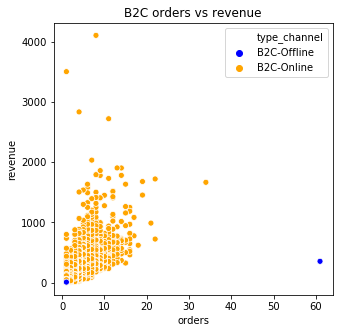

In [50]:
# plot scatterplot
fig, ax = plt.subplots(figsize=(5,5))

palette_dict = {"B2B-Offline":"green", "B2C-Offline":"blue", "B2C-Online":"orange"}


# plot B2C customers
ax = sns.scatterplot(data=customers_orders[customers_orders["customer_type"].eq("B2C")],
                    x="orders", 
                    y="revenue", 
                    hue="type_channel",
                    palette = palette_dict
                    )
ax.title.set_text("B2C orders vs revenue")

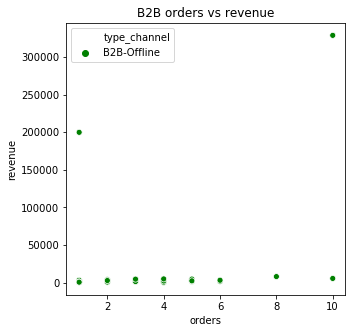

In [51]:
# plot scatterplot
fig, ax = plt.subplots(figsize=(5,5))

# plot B2C customers
ax = sns.scatterplot(data=customers_orders[customers_orders["customer_type"].eq("B2B")],
                    x="orders", 
                    y="revenue", 
                    hue="type_channel",
                    palette=palette_dict)
ax.title.set_text("B2B orders vs revenue")

##### B2B

In [52]:
# b2b customers sorted by revenue
cust_orders_b2b = customers_orders[customers_orders["customer_type"].eq("B2B")].sort_values("revenue", ascending=False)

# share of revenue (among the b2b)
b2b_revenue_2017 = cust_orders_b2b["revenue"].sum()
cust_orders_b2b["b2b_rev_share"] = cust_orders_b2b["revenue"]/b2b_revenue_2017

# share of revenue (from total 2017)
revenue_2017 = customers_orders["revenue"].sum()
cust_orders_b2b["rev_share"] = cust_orders_b2b["revenue"]/revenue_2017

cust_orders_b2b

,customer_id,customer_type,primary_sales_channel,orders,revenue,avg_value,type_channel,b2b_rev_share,rev_share
148,K3519777323,B2B,Offline,10,328671.98,32867.20,B2B-Offline,0.519277,0.181443
6808,K4224177720,B2B,Offline,1,199759.37,199759.37,B2B-Offline,0.315605,0.110277
360,K325261851,B2B,Offline,8,7975.44,996.93,B2B-Offline,0.012601,0.004403
132,K1970313189,B2B,Offline,10,5485.74,548.57,B2B-Offline,0.008667,0.003028
1709,K3894638377,B2B,Offline,4,4866.45,1216.61,B2B-Offline,0.007689,0.002687
1142,K1647036335,B2B,Offline,5,4643.82,928.76,B2B-Offline,0.007337,0.002564
2477,K3529398546,B2B,Offline,3,4574.88,1524.96,B2B-Offline,0.007228,0.002526
2360,K3197061983,B2B,Offline,3,4036.60,1345.53,B2B-Offline,0.006378,0.002228
3661,K2421429863,B2B,Offline,2,3750.98,1875.49,B2B-Offline,0.005926,0.002071
3065,K3962167218,B2B,Offline,2,3607.22,1803.61,B2B-Offline,0.005699,0.001991


In [53]:
cust_orders_b2b.describe().T

,count,mean,std,min,25%,50%,75%,max
orders,48.0,3.208333,2.249901,1.000000,1.000000,3.000000,4.000000,10.000000
revenue,48.0,13186.272292,54565.429748,166.380000,972.795000,2245.940000,3137.447500,328671.980000
avg_value,48.0,5728.490833,28980.251145,41.600000,455.215000,645.185000,1346.590000,199759.370000
b2b_rev_share,48.0,0.020833,0.086209,0.000263,0.001537,0.003548,0.004957,0.519277
rev_share,48.0,0.007279,0.030123,0.000092,0.000537,0.001240,0.001732,0.181443


In [54]:
# share of revenue b2b customers
print("% b2b revenue 2017: ", round(b2b_revenue_2017/revenue_2017,2))

% b2b revenue 2017:  0.35


##### B2C

In [55]:
# b2c customers sorted by revenue
cust_orders_b2c = customers_orders[customers_orders["customer_type"].eq("B2C")].sort_values("revenue", ascending=False)

# share of revenue (among the b2c)
b2c_revenue_2017 = cust_orders_b2c["revenue"].sum()
cust_orders_b2c["b2c_rev_share"] = cust_orders_b2c["revenue"]/b2c_revenue_2017

cust_orders_b2c.head(10)

,customer_id,customer_type,primary_sales_channel,orders,revenue,avg_value,type_channel,b2c_rev_share
240,K3539466631,B2C,Online,8,4103.87,512.98,B2C-Online,0.003482
4664,K0252047,B2C,Online,1,3501.28,3501.28,B2C-Online,0.002971
1643,K457195384,B2C,Online,4,2833.06,708.27,B2C-Online,0.002404
104,K1405453434,B2C,Online,11,2719.44,247.22,B2C-Online,0.002308
412,K2938647829,B2C,Online,7,2032.49,290.36,B2C-Online,0.001725
64,K4068095956,B2C,Online,13,1903.00,146.38,B2C-Online,0.001615
39,K847523894,B2C,Online,14,1901.87,135.85,B2C-Online,0.001614
218,K876522427,B2C,Online,9,1858.20,206.47,B2C-Online,0.001577
254,K2432697760,B2C,Online,8,1790.93,223.87,B2C-Online,0.001520
33,K2780351662,B2C,Online,14,1779.68,127.12,B2C-Online,0.001510


In [56]:
cust_orders_b2c.sort_values("orders", ascending=False).head(10)

,customer_id,customer_type,primary_sales_channel,orders,revenue,avg_value,type_channel,b2c_rev_share
0,K612901966,B2C,Offline,61,352.40,5.78,B2C-Offline,0.000299
1,K524912062,B2C,Online,34,1663.99,48.94,B2C-Online,0.001412
2,K570757436,B2C,Online,22,721.94,32.82,B2C-Online,0.000613
3,K2754230462,B2C,Online,22,1719.59,78.16,B2C-Online,0.001459
4,K4064934009,B2C,Online,21,986.79,46.99,B2C-Online,0.000837
6,K1893922905,B2C,Online,19,1452.26,76.43,B2C-Online,0.001232
5,K1593959895,B2C,Online,19,1677.15,88.27,B2C-Online,0.001423
7,K3104709474,B2C,Online,18,619.17,34.40,B2C-Online,0.000525
8,K3899633289,B2C,Online,17,775.77,45.63,B2C-Online,0.000658
9,K2892324901,B2C,Online,17,1081.48,63.62,B2C-Online,0.000918


In [57]:
cust_orders_b2c.sort_values("avg_value", ascending=False).head(10)

,customer_id,customer_type,primary_sales_channel,orders,revenue,avg_value,type_channel,b2c_rev_share
4664,K0252047,B2C,Online,1,3501.28,3501.28,B2C-Online,0.002971
7396,K0166868,B2C,Online,1,800.00,800.00,B2C-Online,0.000679
5899,K712127861,B2C,Online,1,735.00,735.00,B2C-Online,0.000624
1643,K457195384,B2C,Online,4,2833.06,708.27,B2C-Online,0.002404
8539,K2432068022,B2C,Online,1,569.85,569.85,B2C-Online,0.000484
240,K3539466631,B2C,Online,8,4103.87,512.98,B2C-Online,0.003482
6585,K0147224,B2C,Online,1,480.00,480.00,B2C-Online,0.000407
6334,K0112034,B2C,Online,1,469.34,469.34,B2C-Online,0.000398
6815,K4221877388,B2C,Online,1,434.97,434.97,B2C-Online,0.000369
6040,K7754448,B2C,Online,1,391.39,391.39,B2C-Online,0.000332


In [58]:
cust_orders_b2c.describe().T

,count,mean,std,min,25%,50%,75%,max
orders,11580.0,2.064940,2.196559,1.000000,1.000000,1.000000,2.000000,61.000000
revenue,11580.0,101.769431,177.819097,1.500000,18.890000,38.890000,104.462500,4103.870000
avg_value,11580.0,40.333440,48.928728,1.500000,17.700000,31.800000,50.490000,3501.280000
b2c_rev_share,11580.0,0.000086,0.000151,0.000001,0.000016,0.000033,0.000089,0.003482


#### Clear different behaviour of b2b and b2c customers

**B2B**
- b2b customers (48 from over 11600 in 2017) account for 35% of the total revenue
- from them, 2 b2b customers generate the 83% of the b2b revenue (29% of the whole company)
- 50% of the orders are over 645€, but the highest order is close to 200.000
- At least 50% of the customers makes between 3 to 10 orders in the first semester 2017

**B2C**
- at least 75% of b2c customers orders only 2 products or less
- however, a customers order as much as 61 (but with only 5.48 avg order value)
- 5 b2c customers generated a revenue over 2.000€ each in the first semester 2017
- but in general, revenue is more distributed along the customers

## Summary

Just as reminder of the initial questions:
- The company is growing in terms of customers and conversions and growth is healthy.
- The company should invest more in Offline sales, which look promising.
- There are certain customer segments that behave significantly different than others.


**Evaluation:**
- The company is healthy growing YoY, with an extraordinary peak in March 2017, driven basically by B2B customers (which is Offline as primary sales channel)
- In march, for B2B, the avg amount of orders and, particularly, the avg value of orders increased in 3 digit scale. 

**Recommendation:**
- Investigate which actions took place during March 2017 and if it is possible to "repeat" the success for B2B customers

**Evaluation:**
- The most customers, in terms of numbers, are B2C and, in general, it is growing. However it is detected a decline in the June 2017, which would need to be monitored
- The growth of new B2C customers is driven by a extraordinary peak in Jan 2017 and by adding Offline B2C as a new stream of customers (around 21% of new acquired B2C customers)
- However the avg order value of Offline B2C customers is significantly lower (7-8 times in comparison to Online in the last 2 months)

**Recommendation:**
- New stream of customers offline is a positive asset for the company, but will need investment to lift the avg order value to similar levels as the online B2C to have a greater impact in the overall revenue

**Evaluation:**
- Clear distinction between B2B (48 customers generate 35% of the revenue) and B2C customers (almost 11600 customers for the remaining 65%)
- Among B2B customers, we can distinguish different types: 2 "VIP" customers account for 83% of the B2B revenue
- Despite in general, B2C customers make only 1 or 2 orders, we identify a group which makes several orders, reaching a revenue over the value of 50% of the B2B customers
- One outlier B2C-Offline generate over 60 orders (in 6 months) but with a very low avg value. This behaviour is extremely unusual in comparison to the other customers. In general b2c offline user are in the bottom of amount of orders and revenue generated

**Recommendations:**
- Set a category "B2B Premium", to include at least the big 2 spenders, since they might affect directly the entire revenue
- Contact B2C with level of spend in the range of B2B (a list of 40-60 customers), which can be engaged by B2B adventages
- Check the outlier with 61 orders with low avg value. If it is not a test account, suggest options to increase the avg order value and descend the amount of orders (which might have associated management cost)